---
## <center> Convolutional Neural Network From Scratch </center>
---
##### <left>  Author : Rokhaya SONKO </left>

The aim of this notebook is to build a Convolutional Neural Network, using only numpy.
CNN are composed of two main blocks :

---
* The <b> first block </b> is unique to this type of neural network, since it works as a feature extractor. For this, it performs template matching by applying convolution filtering operations. The first layer filters the image with several convolution kernels, and returns feature maps, which are then normalized (with an activation function) and / or resized.
This process can be repeated several times: we filter the resulting feature maps with new kernels, which gives us new feature maps to normalize and resize, and that we can filter again, and so on. Finally, the values ​​of the latest feature maps are concatenated in a vector. This vector defines the output of the first block, and the input of the second.

---


* The <b> second block </b> is not characteristic of a CNN : it is in fact at the end of all the neural networks used for classification. The values ​​of the input vector are transformed (with several linear combinations and activation functions) to return a new vector output. This last vector contains as many elements as there are classes: the element i represents the probability that the image belongs to class i. Each element is therefore between 0 and 1, and the sum of all is 1. These probabilities are calculated by the last layer of this block (and therefore of the network), which uses a logistic function (binary classification) or a softmax function ( multi-class classification) as an activation function.




---
### Data Set - MNIST
---

We want to handle the MNIST handwritten digit classification problem

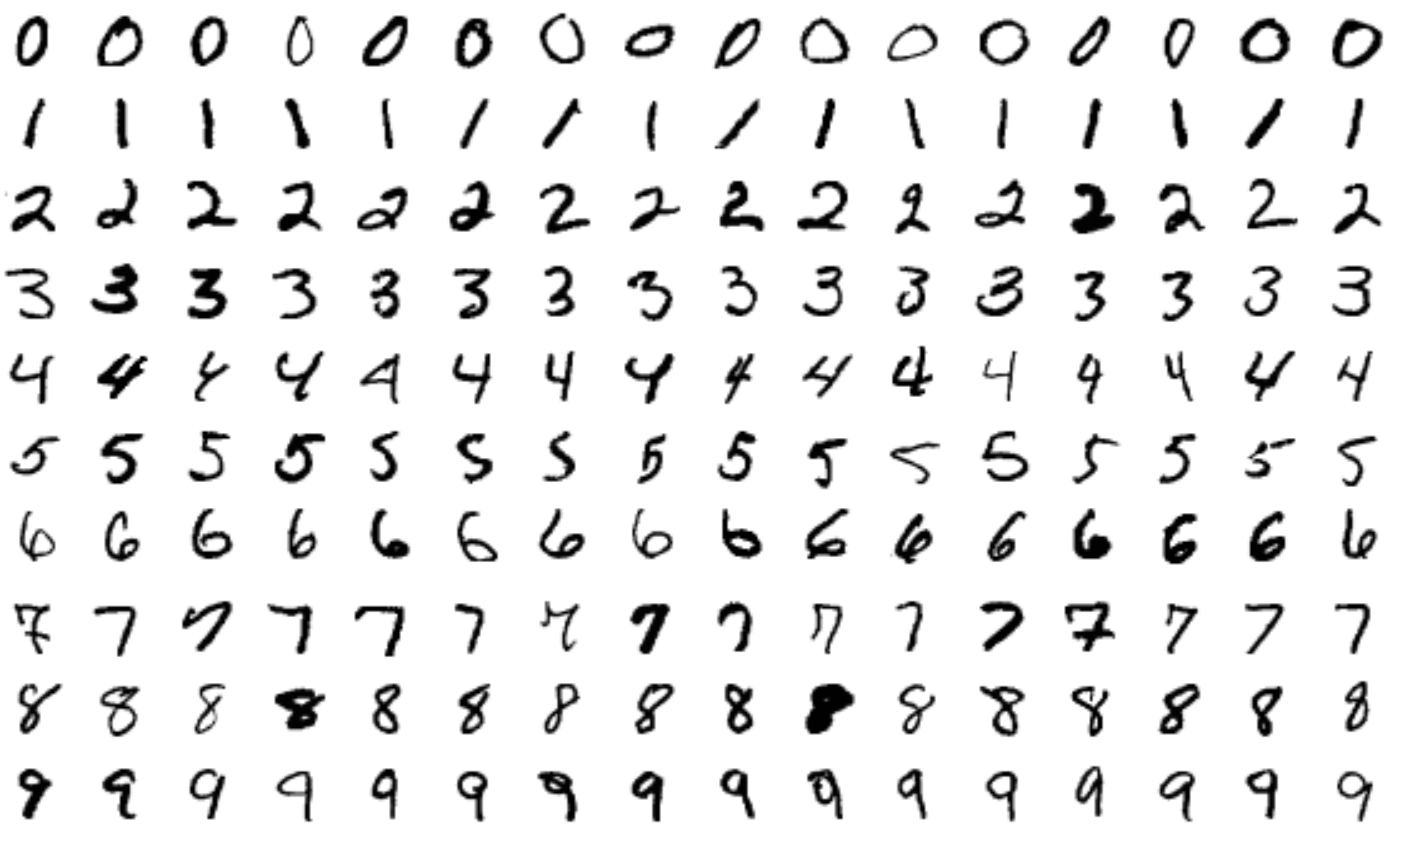

In [50]:
import numpy as np
import mnist

In [51]:
test_images=mnist.test_images()
train_images=mnist.train_images()

test_labels=mnist.test_labels()
train_labels=mnist.train_labels()
test_images.max()

255

---
Our Network
---

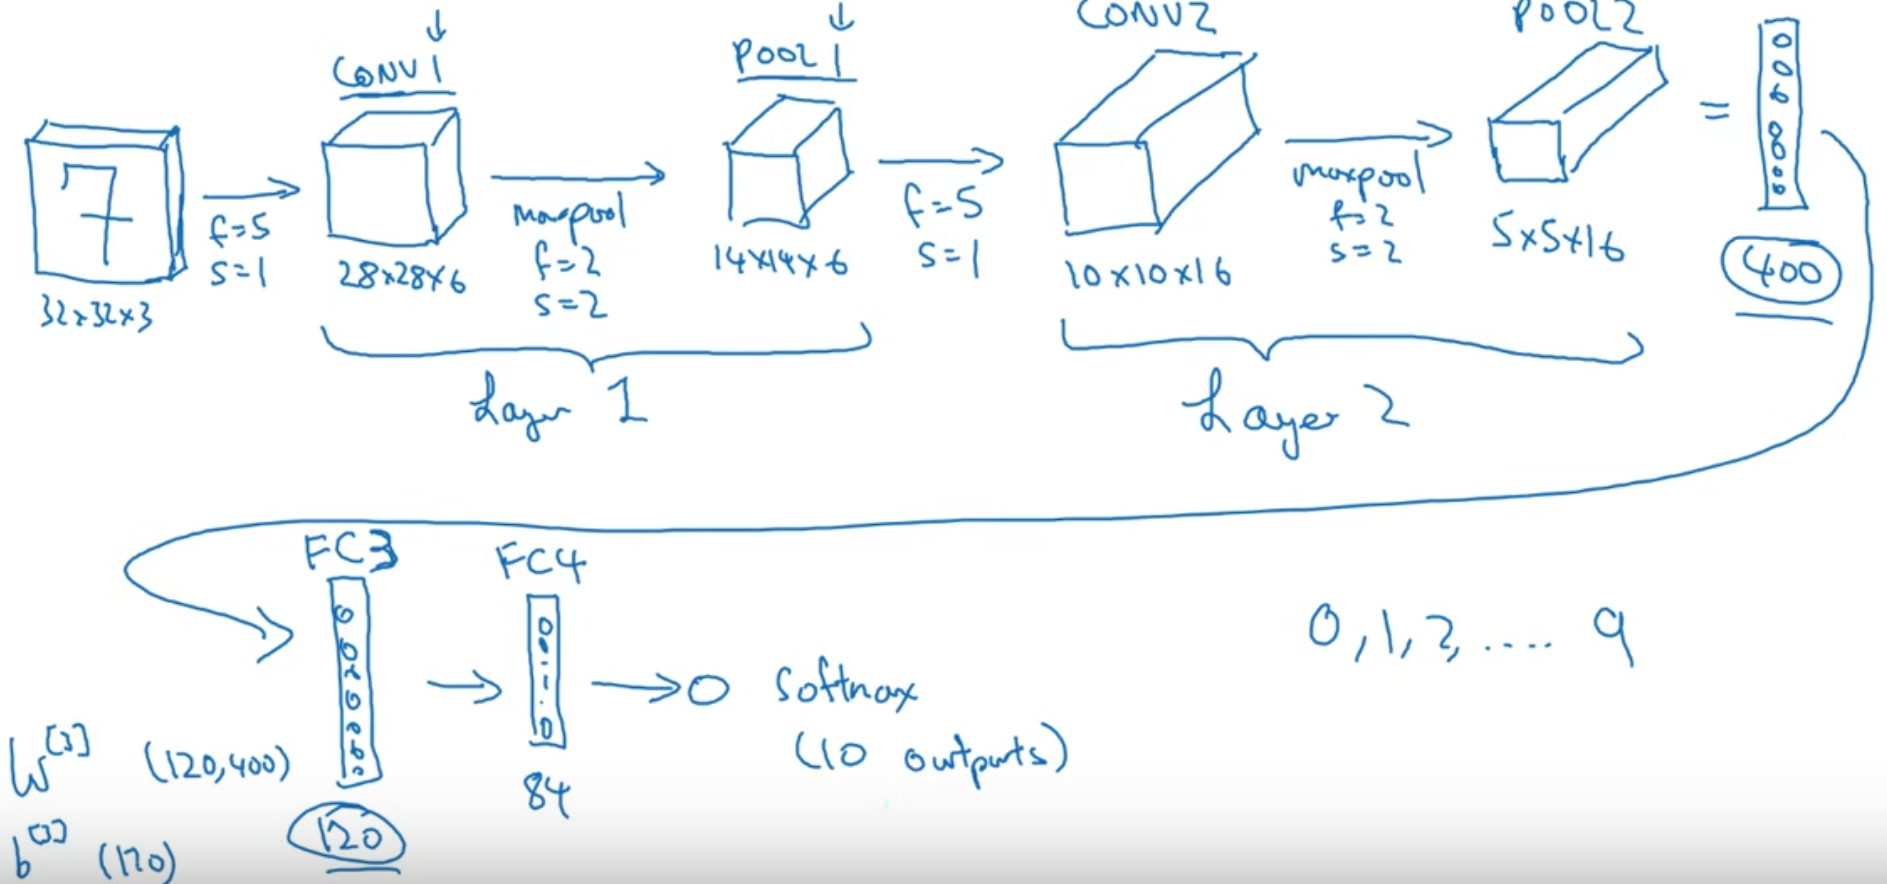

---
### Convolutional Layers
---

The convolutional layer is the key component of convolutional neural networks, and is still at least their first layer.

Its purpose is to locate the presence of a set of features in the images received as input. For this, we perform a convolutional filtering: the principle is to "drag" a window representing the feature on the image, and calculate the product of convolution between the feature and each portion of the scanned image. 

In this implementation, we assume the input is a 2d numpy array as that's
how our MNIST images are stored.

In [52]:
class Conv3x3:
  # A Convolution layer using 3x3 filters.

  def __init__(self, num_filters):
    self.num_filters = num_filters

    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward_propagation(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters)) # we assume here that padding is 1

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backward_propagation(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None


---
### Pooling Layers
---

---
* This type of layer is often placed between two convolution layers: it receives several feature maps as input, and applies to each of them the pooling operation.
The pooling operation consists in reducing the size of the images, while preserving their important characteristics.
For this, the image is cut into regular cells, then the maximum value is kept within each cell. In practice, small square cells are often used to avoid losing too much information. The most common choices are adjacent cells of size 2 ×
2 pixels that do not overlap, or 3 × size cells 3 pixels, distant from each other with a pitch of 2 pixels (which overlap so).

* The same number of feature maps are output as input, but these are much smaller.
The pooling layer reduces the number of parameters and calculations in the network. This improves the efficiency of the network and avoids over-learning.
The maximum values ​​are spotted less accurately in feature maps obtained after pooling than in those received as input - it's actually a big advantage! Indeed, when you want to recognize a dog for example, his ears do not need to be located as accurately as possible: knowing that they are located near the head is enough!

Thus, the pooling layer makes the network less sensitive to the position of features: the fact that a feature is a little higher or lower, or even that it has a slightly different orientation should not cause a radical change in the classification of the image.

---



In [53]:
class MaxPool2x2:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward_propagation(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backward_propagation(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input


---
Fully connected layers
---

In [54]:
# Base Layer class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # Input X is computed into the output Y for every layers
    def forwardProp(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backwardProp(self, output_error, learning_rate):
        raise NotImplementedError
        
    def backwardPropmom(self, output_error, learning_rate):
        raise NotImplementedError# inherit from base class Layer
        
class FullyConnected(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, inputSize, outputSize):
        self.weights = np.random.rand(inputSize, outputSize) - 0.5
        self.bias = np.random.rand(1, outputSize) - 0.5
        self.gamma=0.9
        self.v=0
        self.m=0
        self.m_hat=0
        self.v_hat=0
        self.beta_1=0.9
        self.beta_2=0.999
        self.alpha=0.01
        self.epsilon=1e-8
    # returns output for a given input
    def forwardProp(self, inputData):
        self.input = inputData
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given outputError=dE/dY. Returns inputError=dE/dX.
    def backwardProp(self, outputError, learningRate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        # dBias = outputError

        # update parameters
        self.weights -= learningRate * weightsError
        self.bias -= learningRate * outputError
        return inputError
    
    def backwardPropmom(self, outputError, learningRate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        # dBias = outputError

        # update parameters
        self.v = self.gamma*self.v -learningRate * weightsError
        self.weights += self.v
        self.bias -= learningRate * outputError
        return inputError
    
    def backwardProp_adam(self, outputError, learningRate):
        inputError = np.dot(outputError, self.weights.T)
        weightsError = np.dot(self.input.T, outputError)
        #self.bias -= learningRate * outputError
        m=0
        v=0
        v_hat=0
        m_hat=0
        for t in range(1,30):
            m = self.beta_1 * m + (1 - self.beta_1) * outputError
            v = self.beta_2 * v + (1 - self.beta_2) * np.power(outputError, 2)
            m_hat = m / (1 - np.power(self.beta_1, t)) + (1 - self.beta_1) * outputError / (1 - np.power(self.beta_1, t))
            v_hat = v / (1 - np.power(self.beta_2, t))
            self.weights = self.weights - learningRate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return inputError

---
Sotfmax Layer ( Output Layer)
---

In [55]:
import numpy as np

class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward_propagation(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backward_propagation(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)


In [56]:
class CNN:
    def __init__(self):
        self.layers = []
        self.mse_loss= None
        self.mse_loss_derivative = None

    # add layer to network
    def add_layer(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use_lossfunc(self, mse_loss, mse_loss_derivative):
        self.mse_loss = mse_loss
        self.mse_loss_derivative = mse_loss_derivative

    # predict output for given input
    def predict_output(self, inputData):
        # sample dimension first
        samples = len(inputData)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = inputData[i]
            for layer in self.layers:
                output = layer.forwardProp(output)
            result.append(output)

        return result
    
    def accuracy(self,x_train,y_train,x_test,y_test):
        train_accuracy=[]
        test_accuracy=[]
        size=len(x_train)
        train_output=self.predict_output(x_train[0:size])
        test_output=self.predict_output(x_test[0:size])
        for i in range(1,size):
            delta_train=mse_loss(y_train[0:i],train_output)
            delta_test=mse_loss(y_train[0:i],test_output)
            train_accuracy.append(delta_train)
            test_accuracy.append(delta_test)
        fig, ax = plt.subplots()
        ax.plot(train_accuracy, '-r', label=' Training accuracy')
        ax.plot(test_accuracy, '-g', label=' Testing accuracy')
        leg = ax.legend(title='Learning curves');

        plt.show()
        return train_accuracy,test_accuracy

    
    def forward(image, label):
        '''
        Completes a forward pass of the CNN and calculates the accuracy and
        cross-entropy loss.
        - image is a 2d numpy array
        - label is a digit
        '''
        # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
        # to work with. This is standard practice.
        out = conv.forwardProp((image / 255) - 0.5)
        out = pool.forwardProp(out)
        out = softmax.forwardProp(out)

        # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
        loss = -np.log(out[label])
        acc = 1 if np.argmax(out) == label else 0

        return out, loss, acc
    
    
    def train(im, label, lr=.005):
        # Forward
        out, loss, acc = forward(im, label)

        # Calculate initial gradient
        gradient = np.zeros(10)
        gradient[label] = -1 / out[label]

       # Backprop
        gradient = softmax.backward_propagation(gradient, lr)
        gradient = pool.backward_propagation(gradient)
        gradient = conv.backward_propagation(gradient, lr)

        return loss, acc

    

In [ ]:
# We only use the first 1k examples of each set in the interest of time.
# Feel free to change this if you want.
train_images = mnist.train_images()[:1000]
train_labels = mnist.train_labels()[:1000]
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2x2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward_propagation((image / 255) - 0.5)
  out = pool.forward_propagation(out)
  out = softmax.forward_propagation(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backward_propagation(gradient, lr)
  gradient = pool.backward_propagation(gradient)
  gradient = conv.backward_propagation(gradient, lr)

  return loss, acc

print('MNIST CNN initialized!')

# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i > 0 and i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.227 | Accuracy: 21%
[Step 200] Past 100 steps: Average Loss 1.947 | Accuracy: 38%
[Step 300] Past 100 steps: Average Loss 1.398 | Accuracy: 61%
[Step 400] Past 100 steps: Average Loss 1.207 | Accuracy: 60%
[Step 500] Past 100 steps: Average Loss 0.970 | Accuracy: 69%
[Step 600] Past 100 steps: Average Loss 0.858 | Accuracy: 75%


In [ ]:
cnn=CNN()
cnn.add_layer(Conv3x3(8))
cnn.add_layer(MaxPool2x2())
cnn.add_layer(Conv3x3(4))
cnn.add_layer(MaxPool2x2())
cnn.add_layer(FullyConnected(300,100))
cnn.add_layer(FullyConnected(100,50))
cnn.add_layer(Softmax(50,10))


In [ ]:
def dropout(X, drop_probability):
    keep_probability = 1 - drop_probability
    mask = nd.random_uniform(0, 1.0, X.shape, ctx=X.context) < keep_probability
    #############################
    #  Avoid division by 0 when scaling
    #############################
    if keep_probability > 0.0:
        scale = (1/keep_probability)
    else:
        scale = 0.0
    return mask * X * scale